## Figure 2: Illustrative Explanation of the idea based on the toy example

In [1]:
#%%
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import matplotlib as mpl
import matplotlib.pyplot as plt
from loss_cal.tasks.toy_example import ToyExample
from loss_cal.npe import load_npes
from loss_cal.predictor import load_predictors
from loss_cal.costs import RevGaussCost, expected_posterior_costs_given_posterior_samples
from loss_cal.utils.analysis import find_optimal_action


plot_config_file = "loss_cal/utils/.matplotlibrc"
color_npe = "#377eb8"
color_nn = "#ff7f00"
color_post = 'k' #"#4daf4a"
save_dir = "./paper/fig2/"

figsize=(2.5,2)
seed = 0 

In [3]:
mpl.matplotlib_fname()

'/Users/mgorecki/opt/miniconda3/envs/losscal-py310/lib/python3.10/site-packages/matplotlib/mpl-data/matplotlibrc'

In [4]:
toy = ToyExample(action_type="continuous")
factor, exponential = 3, 1

parameter_range = (toy.param_high[0] - toy.param_low[0]).squeeze().item()
action_range = toy.action_high - toy.action_low

cost_fn = RevGaussCost(
    parameter_range=parameter_range, action_range=action_range, factor=factor, exponential=exponential
)

### Load NPE

In [5]:
flow = "maf"# "nsf" #
npe_posteriors, num_simulations_npe = load_npes(f"./results/toy_example/npe/{seed}/", flow=flow)

Loading npe trained on ... simulations:
-  500
-  1000
-  5000
-  10000
-  50000
-  100000


In [6]:
num_samples = 1000

### Load NN

In [7]:
experiment = "vary_sim"
task_name = "toy_example"
action_type = "continuous"
dir = f"./results/{task_name}/{action_type}/nn/fc/{experiment}/{seed}/*_factor_{factor}_exp_{exponential}"
models, num_simulations_nn = load_predictors(task_name, action_type="continuous", dir=dir)

Load data from './data/toy_example', device = cpu.
Loading models:
task_name =  toy_example
- 500 simulations,	 best val loss 0.0484:	./results/toy_example/continuous/nn/fc/vary_sim/0/2023-10-18T17_39_38_param_0_factor_3_exp_1/best_model.pt
task_name =  toy_example
- 1000 simulations,	 best val loss 0.0474:	./results/toy_example/continuous/nn/fc/vary_sim/0/2023-10-18T17_40_53_param_0_factor_3_exp_1/best_model.pt
task_name =  toy_example
- 5000 simulations,	 best val loss 0.0468:	./results/toy_example/continuous/nn/fc/vary_sim/0/2023-10-18T17_43_21_param_0_factor_3_exp_1/best_model.pt
task_name =  toy_example
- 10000 simulations,	 best val loss 0.0469:	./results/toy_example/continuous/nn/fc/vary_sim/0/2023-10-18T17_45_42_param_0_factor_3_exp_1/best_model.pt
task_name =  toy_example
- 50000 simulations,	 best val loss 0.0469:	./results/toy_example/continuous/nn/fc/vary_sim/0/2023-10-18T17_46_36_param_0_factor_3_exp_1/best_model.pt
task_name =  toy_example
- 100000 simulations,	 best val 

In [8]:
num_simulations = 1_000
model = models[num_simulations_nn.index(num_simulations)]
npe_posterior = npe_posteriors[num_simulations_npe.index(num_simulations)]

## Plotting

In [9]:
x_o = torch.Tensor([140.])

### Panel A: Joint

/Users/mgorecki/opt/miniconda3/envs/losscal-py310/lib/python3.10/site-packages/matplotlib/ticker.py:1717: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  self.locs = np.asarray(locs)


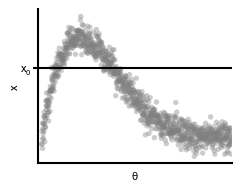

In [10]:
with mpl.rc_context(fname=plot_config_file):
    # plt.rcParams["axes.spines.top"]=True
    # plt.rcParams["axes.spines.right"]=True
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    thetas = torch.linspace(0, 5, 1000)
    ax.scatter(thetas, toy.get_simulator()(thetas), c='grey', alpha=0.4, s=15, edgecolors='none')
    ax.hlines(y=x_o, xmin=thetas.min().item()-0.1, xmax= thetas.max().item(), colors='k', linestyles='solid')
    # ax.set_xticklabels("")
    ax.tick_params(axis="y", pad=1)
    ax.set_yticks([x_o])
    ax.set_yticklabels([r"$x_0$"])
    ax.xaxis.set_major_locator(mpl.ticker.NullLocator())
    # ax.yaxis.set_major_locator(mpl.ticker.NullLocator())
    ax.set_xlabel(r"$\theta$")
    ax.set_ylabel("x", labelpad=0)
    ax.set_xlim(thetas.min().item()-0.1, thetas.max().item())
    #ax.set_title("joint")
    plt.savefig('./paper/fig2/panel_a.svg')
   
    plt.show()

### Panel B: posterior distribution

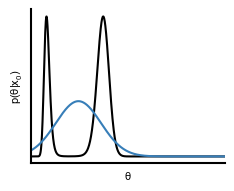

In [11]:
resolution = 1000
posterior_evals = toy.gt_posterior(torch.Tensor([x_o]))
with mpl.rc_context(fname=plot_config_file):
    # plt.rcParams["axes.spines.top"]=True
    # plt.rcParams["axes.spines.right"]=True
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    thetas = torch.linspace(toy.param_low.item(), toy.param_high.item(), resolution)
    ax.plot(thetas, posterior_evals, c=color_post, label="posterior")
    ax.plot(thetas, npe_posterior.log_prob(thetas.reshape(-1, 1), x=x_o).exp(), c=color_npe, label=f"NPE")
    ax.xaxis.set_major_locator(mpl.ticker.NullLocator())
    ax.yaxis.set_major_locator(mpl.ticker.NullLocator())
    ax.set_xlabel(r"$\theta$")
    ax.set_ylabel(r"$p(\theta|x_0)$")
    ax.set_xlim(toy.param_low.item(), toy.param_high.item())
    #ax.set_title("ground truth")
    #plt.legend()
    plt.savefig('./paper/fig2/panel_b.svg')
    plt.show()

### Panel C: Cost function

In [12]:
import matplotlib.style as style
style.use("seaborn-colorblind")

/var/folders/94/0gpvl07x6ks__mzyr78t4gg00006zk/T/ipykernel_92062/1083190338.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  style.use("seaborn-colorblind")


/var/folders/94/0gpvl07x6ks__mzyr78t4gg00006zk/T/ipykernel_92062/743183872.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap("Greys", len(thetas)+4)


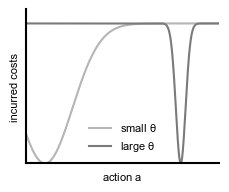

In [13]:
factor = 3
exponential = 1
cost_fn = RevGaussCost(parameter_range=toy.param_high - toy.param_low, action_range=toy.action_high-toy.action_low, factor=factor, exponential=exponential)


color_costs = "#984ea3"
# colors = cmap(torch.linspace(0, cmap.N, 10).numpy())

with mpl.rc_context(fname=plot_config_file):
    # plt.rcParams["axes.spines.top"]=True
    # plt.rcParams["axes.spines.right"]=True
    resolution = 1000
    actions = torch.arange(toy.action_low, toy.action_high, (toy.action_high - toy.action_low) / resolution)

    fig, ax = plt.subplots(1, 1, figsize=figsize)
    thetas = torch.Tensor([0.5,4.]) #torch.arange(toy.param_low.item(), toy.param_high.item()+0.01, 1.2)
    cmap = mpl.cm.get_cmap("Greys", len(thetas)+4)
    # ax.set_prop_cycle(color=["#0072B2", "#009E73", "#D55E00", "#CC79A7","#F0E442", "#56B4E9"])
    labels = [r"small $\theta$", r"large $\theta$"]
    for i, theta in enumerate(thetas):
        ax.plot(actions, cost_fn(theta, actions), label=labels[i],  c=cmap(i+2)) #c=f"C{i}")#,

    ax.xaxis.set_major_locator(mpl.ticker.NullLocator())
    ax.yaxis.set_major_locator(mpl.ticker.NullLocator())
    ax.set_xlabel(r"action $a$")
    ax.set_ylabel("incurred costs")
    ax.set_xlim(actions.min().item(), actions.max().item())
    ax.set_ylim(0, 1.1)
    ax.legend()
    # ax.legend(
    #     loc="upper center",
    #     bbox_to_anchor=(0.6, -0.15),
    #     fancybox=True,
    #     shadow=True,
    #     ncol=6,
    # )
    plt.savefig('./paper/fig2/panel_c.svg')
    plt.show()

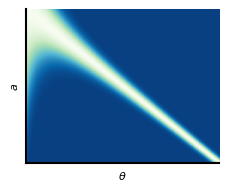

In [14]:
#cost_fn(thetas, actions.T).shape

with mpl.rc_context(fname=plot_config_file):
    resolution = 1000
    actions = torch.arange(toy.action_low, toy.action_high+0.001, (toy.action_high - toy.action_low) / resolution).unsqueeze(1)
    thetas = torch.arange(toy.param_low.item(), toy.param_high.item()+0.001, 0.01).unsqueeze(1)

    fig, ax = plt.subplots(1, 1, figsize=figsize)
    im=ax.imshow(cost_fn(thetas, actions.T).T, aspect="auto", cmap="GnBu", vmin=0, vmax=1)
    ax.set_xticks([])#ticks=thetas.numpy().squeeze()[::100]*100, labels= thetas.numpy()[::100].squeeze())
    ax.set_yticks([]) #ticks=actions.numpy().squeeze()[::200]*10, labels= actions.numpy()[::200].squeeze())
    ax.set_ylabel(r"$a$")
    ax.set_xlabel(r"$\theta$")
    #fig.colorbar(im, orientation='vertical')
# plt.savefig('./paper/fig2/panel_c.svg')
plt.show()

### Panel D: expected costs

Compute Expected Costs

In [15]:
a_grid = torch.arange(toy.action_low, toy.action_high, 0.5)
expected_posterior_costs = toy.expected_posterior_costs(x=x_o, a=a_grid, cost_fn=cost_fn).squeeze()
predicted_costs_nn = model(x_o.repeat(a_grid.shape), a_grid).detach()

npe_samples = npe_posterior.sample((num_samples * 10,), x=x_o, show_progress_bars=False)
predicted_costs_npe = expected_posterior_costs_given_posterior_samples(
    post_samples=npe_samples, actions=toy.actions, a=a_grid, param=0, cost_fn=cost_fn
).squeeze()

Find optimal actions

In [16]:
post_action, _, post_costs = find_optimal_action(
    x_o, task=toy, dist="posterior", cost_fn=cost_fn, param=0, verbose=False
)
nn_action, nn_estimated_costs, nn_costs = find_optimal_action(
    x_o, task=toy, dist="nn", nn=model, cost_fn=cost_fn, param=0, verbose=False
)
npe_action, npe_estimated_costs, npe_costs = find_optimal_action(
    x_o, task=toy, dist="npe", npe=None, npe_samples=npe_samples, cost_fn=cost_fn, param=0, verbose=False
)

Plot

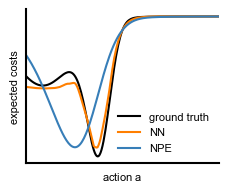

In [17]:
with mpl.rc_context(fname=plot_config_file):
    # plt.rcParams["axes.spines.top"]=True
    # plt.rcParams["axes.spines.right"]=True
    fig, ax = plt.subplots(1, 1, figsize=figsize)

    # expected costs
    ax.plot(a_grid, expected_posterior_costs, c=color_post, label="ground truth")
    ax.plot(a_grid, predicted_costs_nn, c=color_nn, label="NN")
    ax.plot(a_grid, predicted_costs_npe, c=color_npe, label="NPE")
    # optimal actions
    # ax.scatter(post_action, post_costs, c=color_post, s=30)
    # ax.scatter(nn_action, nn_costs, c=color_nn, s=30)
    # ax.axvline(x=npe_action.item(), ymin=0, ymax=1, c=color_npe, linestyle='dashed')
    # ax.axvline(x=post_action.item(), ymin=0, ymax=1, c=color_post, linestyle='dashed')
    # ax.axvline(x=nn_action.item(), ymin=0, ymax=1, c=color_nn, linestyle='dashed')
    #ax.scatter(nn_action, nn_estimated_costs, marker="o", facecolors="none", edgecolors=color_nn, s=30)
    # ax.scatter(npe_action, npe_costs, c=color_npe, s=30)
    #ax.scatter(npe_action, npe_estimated_costs, marker="o", facecolors="none", edgecolors=color_npe, s=30)

    ax.xaxis.set_major_locator(mpl.ticker.NullLocator())
    ax.yaxis.set_major_locator(mpl.ticker.NullLocator())
    ax.set_xlabel(r"action $a$")
    ax.set_ylabel("expected costs")
    ax.set_xlim(a_grid.min().item(), a_grid.max().item())

    # ax.set_title("expected costs")
    plt.legend()
    plt.savefig('./paper/fig2/panel_d.svg')
    plt.show()

### Combine figures to one multipanel figure

In [27]:
import time
import IPython.display as IPd
from svgutils.compose import *

def svg(img):
    IPd.display(IPd.HTML('<img src="{}" / >'.format(img, time.time())))

# > Inkscape pixel is 1/90 of an inch, other software usually uses 1/72.
# > http://www.inkscapeforum.com/viewtopic.php?f=6&t=5964
svg_scale = 1.25  # set this to 1.25 for Inkscape, 1.0 otherwise

# Panel letters in Helvetica Neue, 12pt, Medium
kwargs_text = {'size': '12pt', 'font': 'Arial', 'weight': '800'}

f = Figure("21.59cm", "5.0cm", #20.3 = width of document (check!)
           
    Panel(
          SVG("./paper/fig2/panel_a.svg").scale(svg_scale),
          Text("a", 10., 2.0, **kwargs_text),
    ).move(0, 20),
    
    Panel(
          SVG("./paper/fig2/panel_b.svg").scale(svg_scale),
          Text("b", 5., 2.0, **kwargs_text),
    ).move(210, 20),
    
    Panel(
          SVG("./paper/fig2/panel_c.svg").scale(svg_scale),
          Text("c", 5., 2.0, **kwargs_text),
    ).move(410, 20),
    
    Panel(
          SVG("./paper/fig2/panel_d.svg").scale(svg_scale),
          Text("d", 5., 2.0, **kwargs_text),
    ).move(610, 20),
)

f

In [19]:
# !mkdir -p fig
f.save("./paper/fig2/fig2.svg")
# svg("./paper/fig2/fig2.png")

In [26]:
f2 = Figure(
    "21.59cm",
    "12.0cm",  # 20.3 = width of document (check!)
    Panel(
        SVG("./paper/fig2/panel_a.svg").scale(svg_scale),
        Text("a", 15.0, 2.0, **kwargs_text),
    ).move(-4, 30),
    Panel(
        SVG("./paper/fig2/panel_b.svg").scale(svg_scale),
        Text("b", 5.0, 2.0, **kwargs_text),
    ).move(254, 30),
    #     Panel(
    #           SVG("./paper/fig2/panel_c.svg").scale(svg_scale),
    #           Text("C", 5., 2.0, **kwargs_text),
    #     ).move(1.25, 187.25),
    Panel(
        SVG("./paper/fig2/panel_c.svg").scale(svg_scale),
        Text("c", 5.0, 2.0, **kwargs_text),
    ).move(5, 210),
    Panel(
        SVG("./paper/fig2/panel_d.svg").scale(svg_scale),
        Text("d", 5.0, 2.0, **kwargs_text),
    ).move(254, 210),
)
f2

In [21]:
f2.save("./paper/fig2/fig2_alternative.svg")